## Concrete Compressive Strength Prediction

The Compressive Strength of Concrete determines the quality of Concrete. This is generally determined by a standard crushing test on a concrete cylinder. This requires engineers to build small concrete cylinders with different combinations of raw materials and test these cylinders for strength variations with a change in each raw material. The recommended wait time for testing the cylinder is 28 days to ensure correct results. This consumes a lot of time and requires a lot of labour to prepare different prototypes and test them. Also, this method is prone to human error and one small mistake can cause the wait time to drastically increase.

One way of reducing the wait time and reducing the number of combinations to try is to make use of digital simulations, where we can provide information to the computer about what we know and the computer tries different combinations to predict the compressive strength. This way we can reduce the number of combinations we can try physically and reduce the amount of time for experimentation. But, to design such software we have to know the relations between all the raw materials and how one material affects the strength.

### Objective
To predict the concrete strength using the data available in file "concrete.csv". Apply feature engineering and model tuning to obtain a score above 85%.

#### Dataset Description

The dataset consists of 1030 instances with 9 attributes and has no missing values. There are 8 input variables and 1 output variable. Seven input variables represent the amount of raw material (measured in kg/m³) and one represents Age (in Days). The target variable is Concrete Compressive Strength measured in (MPa — Mega Pascal). We shall explore the data to see how input features are affecting compressive strength.


- Cement (cement) -- quantitative -- kg in a m3 mixture -- Input Variable
- Blast Furnace Slag (slag) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fly Ash (ash) -- quantitative -- kg in a m3 mixture -- Input Variable
- Water (water) -- quantitative -- kg in a m3 mixture -- Input Variable
- Superplasticizer (superplastic) -- quantitative -- kg in a m3 mixture -- Input Variable
- Coarse Aggregate (coarseagg) -- quantitative -- kg in a m3 mixture -- Input Variable
- Fine Aggregate (fineagg) -- quantitative -- kg in a m3 mixture -- Input Variable
- Age (age) -- quantitative -- Day (1~365) -- Input Variable
- Concrete compressive strength (strength) -- quantitative -- MPa -- Output Variable

In [375]:
# Import libraries
import pandas as pd
import numpy as np

# Import visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
from scipy import stats

# Import Scikit Learn libs for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

### Dataset inspection

In [376]:
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [377]:
features = ['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']
target = ['strength']

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [379]:
len(df)

1030

In [380]:
print('Number of missing values in dataset:',df.isnull().sum().sum())

Number of missing values in dataset: 0


**Zero's or Missing Values?**

According to the domain knowledge, the zero's in slag, ash and superplastic, do not represent null values. It is sometime practical leave out certain chemincal components depending on the type of repair. For instance, blast furnace slag cannot be used in Reinforced Cement Concrete (RCC) works. As the initial setting time is high, this cement is not used for emergency or repair works and the early strength is low.

With Fly Ash, the winter season is problematic for concrete pouring, and mixtures high in fly ash are even more susceptible to low temperatures. Low temperatures lengthen setting times and cause slow strength gain even in concrete mixtures without fly ash. When fly ash is added, low temperatures exaggerate these problems. Some regions have bans or restrictions on using fly ash in the winter months.

In the use of superplasticizers does not significantly affect surface tension of water and does not entrain a significant amount of air. The main disadvantage of superplasticizer usage is loss of workability as a result of rapid slump loss and incompatibility of cement and superplasticizers, and hence it is not always used.

In [381]:
### number of unique values in each column
pd.DataFrame(df.nunique(),columns=['total unique'])

,total unique
cement,278
slag,185
ash,156
water,195
superplastic,111
coarseagg,284
fineagg,302
age,14
strength,845


### Data Distribution

In [382]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


##### Observations
- All of the data in the dataset is numerical
- No null/NAN data
- Age data appears to have outliers because max value is very large as compared to 3rd IQR value
- Slag and ash, age has wide difference in mean and 50% values,indicating mean > median, so being a right tailed skewness in data.
- Also, slag and ash, superplastic has min value as 0, which cannot be in he composition of cement.
- In cement., min = 102, std = 104, range is 102 - 540, does the nearing value of std and min indicate something?
- In col Water , std is < min value, shuld we consider this variable for further analysis
- considering the difference b/w ( Q1,median ) and (Q3 and median) in columns slag,ash there are huge number of outliers.
- Other columns has very little diff b/w ( Q1,median ) and (Q3 and median), so there might be 1 or 2 outliers

### Exploratory Data Analysis

##### Distribution of independent variables

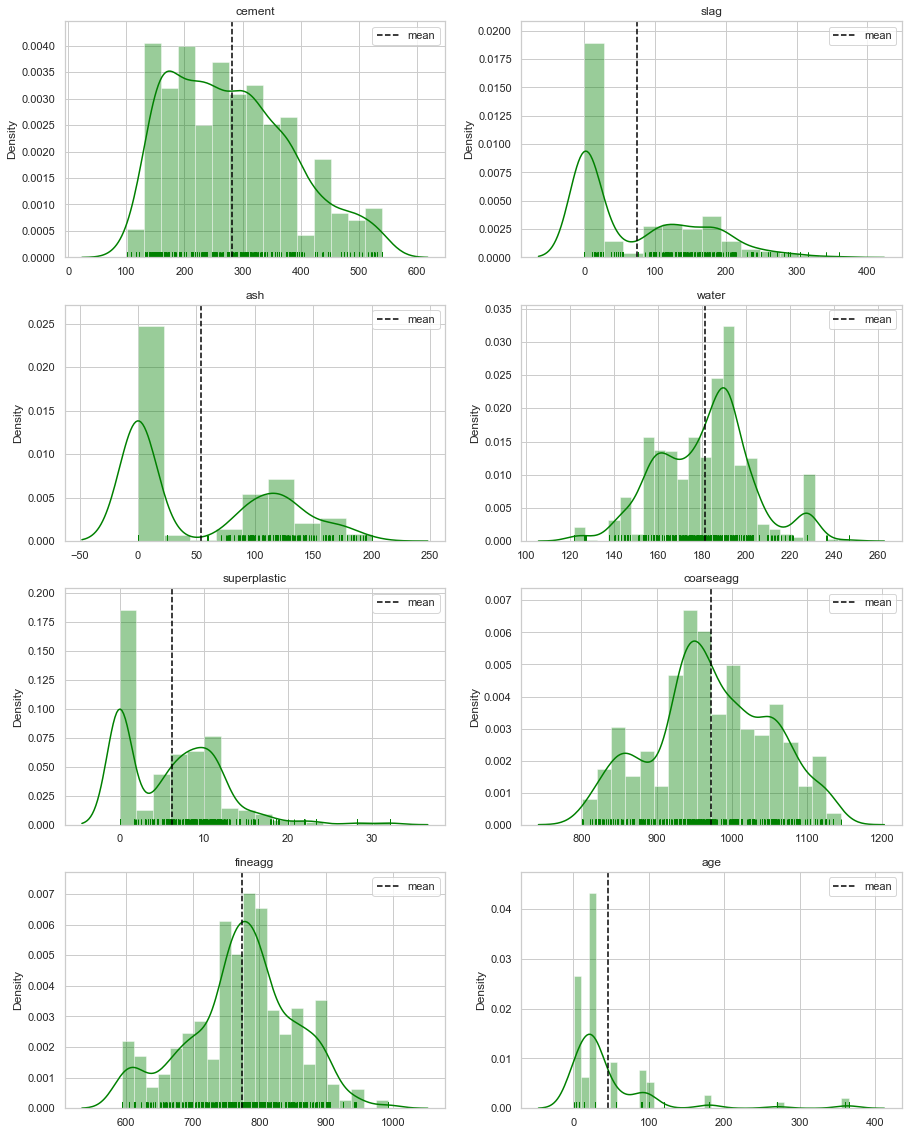

In [383]:
import itertools

cols = [i for i in df.columns if i != 'strength']

fig = plt.figure(figsize=(15, 20))

for i,j in itertools.zip_longest(cols, range(len(cols))):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(df[i],color='green',rug=True)
    plt.axvline(df[i].mean(),linestyle="dashed",label="mean", color='black')
    plt.legend()
    plt.title(i)
    plt.xlabel("")

**Observation**

- cement is almost a normally distributed
- slag has three gaussians and rightly skewed
- ash has two guassians and rightly skewed
- water has three gaussians and let skewed
- superplastic has two guassians and almost normally distributed
- coarseagg has three guasssians and almost normally distributed
- fineagg has almost two guassians and looks like a normal distribution
- age has multiple guassinas and rightly skewed

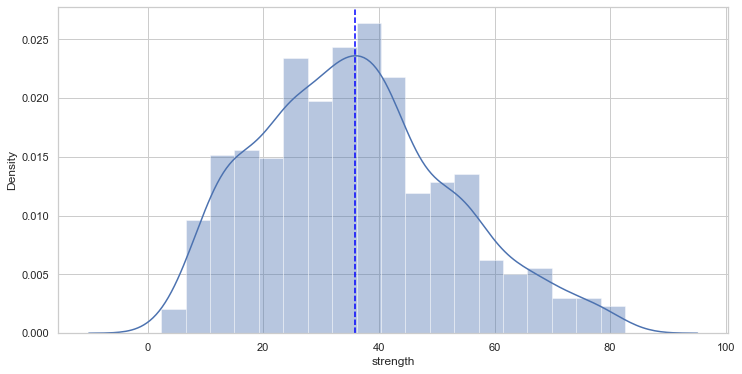

In [384]:
fig = plt.figure(figsize=(12, 6))
plt.axvline(df.strength.mean(),linestyle="dashed",label="mean", color='blue')
sns.distplot(df.strength);

**Observation**

The target variable has the distribution of data to be almost normal, but with lesser values on higher range, / higher values on lesser range

Let us check the skewness:

In [385]:
print("Skewness = ",df['strength'].skew())

Skewness =  0.41697728841071807


**Observations:**
It is positively, lightly skewed, as the skew value is < 0.5. For analysis, we can log transform this variable for better analysis, optional.

##### Plotting histograms of multiple columns together

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd823e45610>,
      dtype=object)

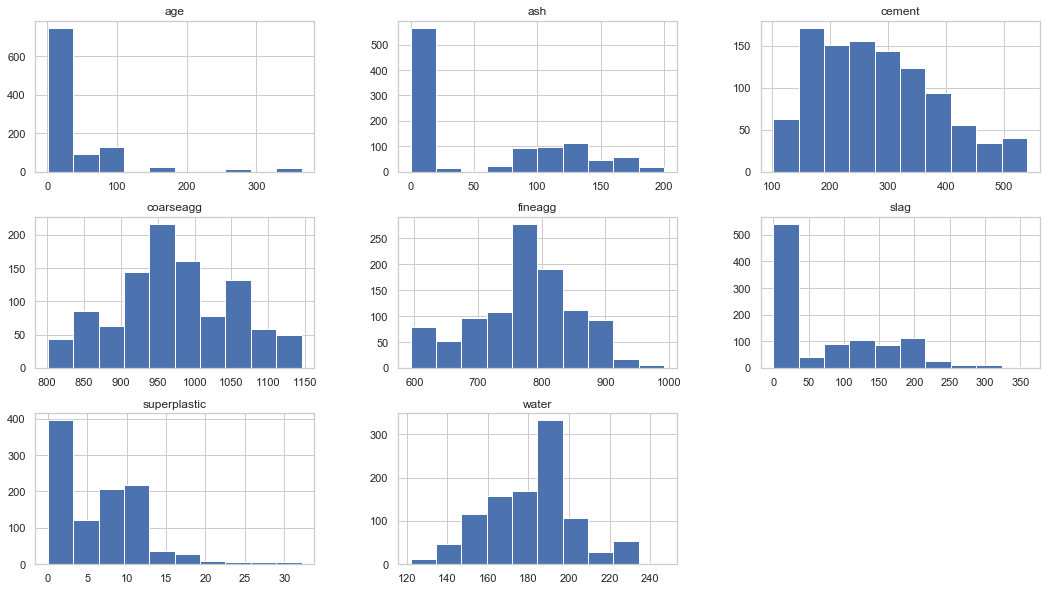

In [386]:
df.hist(['cement','slag','ash','water','superplastic','coarseagg','fineagg','age'], figsize=(18,10))

**Observation**
Histograms shows us the data distribution for a single continuous variable.

The X-axis shows the range of values and Y-axis represent the number of values in that range. For example, in the above histogram of "AgeInDays", there are around 800 rows in data that has a value between 0 to 25.

The ideal outcome for histogram is a bell curve or slightly skewed bell curve. If there is too much skewness, then outlier treatment should be done and the column should be re-examined, if that also does not solve the problem then only reject the column.

**Selected Continuous Variables:**

- Cement: The distribution is good.
- Slag: The distribution is good.
- Ash: The distribution is good.
- Water: The distribution is good.
- Superplastic: The distribution is good.
- Coarse Aggregate: The distribution is good.
- Fine Aggregate: The distribution is good.
- Age In Days: The distribution is skewed, but the tail is thick, hence acceptable.

##### Variables summary

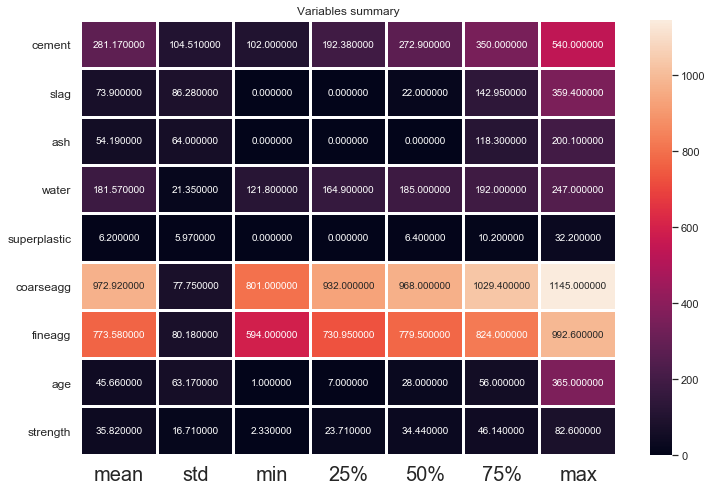

In [387]:
plt.figure(figsize=(12,8))
sns.heatmap(round(df.describe()[1:].transpose(),2),linewidth=2,annot=True,fmt="f")
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.title("Variables summary")
plt.show()

### Multi-Variate Analysis

##### Pair plot

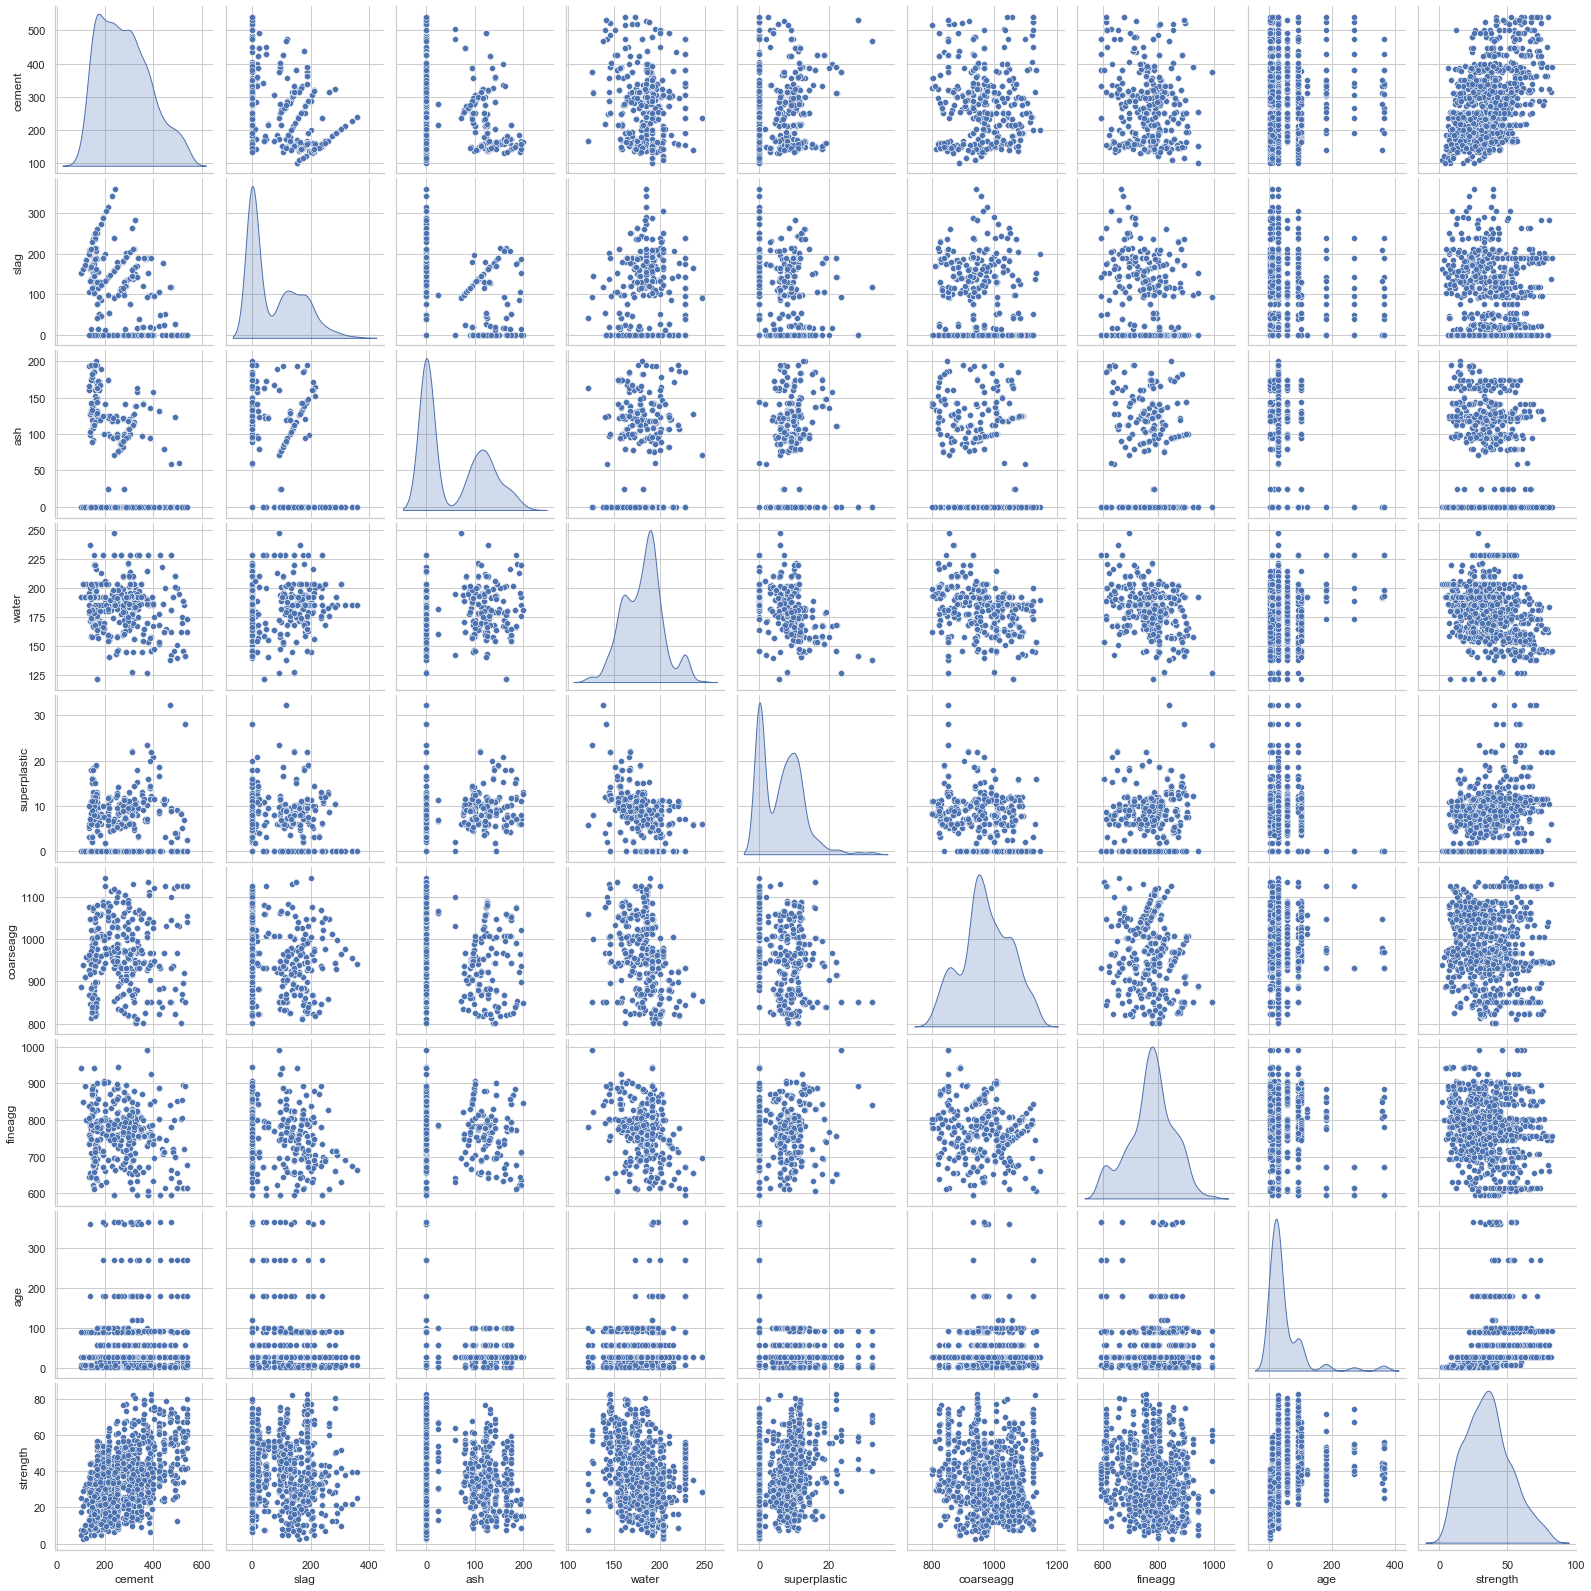

In [388]:
# plt.figure(figsize=(8,8))
# sns.pairplot(df[features],palette='coolwarm')
# plt.show()

sns.pairplot(df, diag_kind='kde')

**Observations**

**Diagonal analysis + dist plots analysis**

- Distribution of cement appears nearly normal
- Slag and ash has 2 gaussians and is skewed
- Water and Superplastic have near normal distributions
- Age data has long tail which confirms the presence of outliers
- Strength is normally distributed

**Off-diagonal analysis with strength**
- Cement has strong correlation with strength
- Slag is a very weak predictor because the distribution is like a cloud
- Ash, coarseagg and fineagg are also weak predictors
- Water appears to have a negative correlation with strength
- Superplastic appears to have positive correlation with strength
- Age also has strong correlation with strength

**Off-diagonal analysis between other features**
- Cement and slag have strong correlation
- Water and super plastic have strong negative correlation


##### Strength vs (Cement, Age, Water)

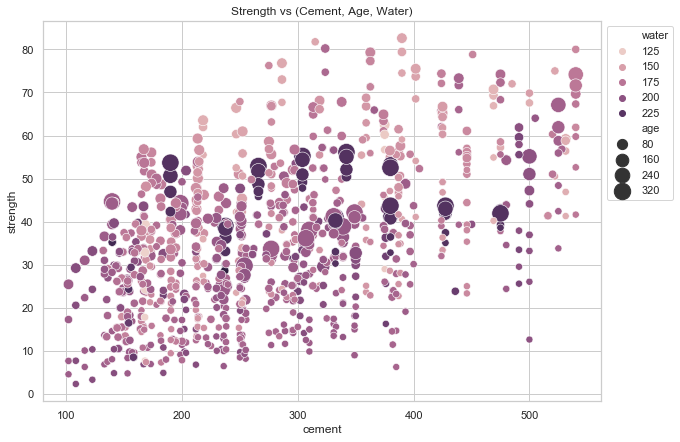

In [389]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="strength", x="cement", hue="water", size="age", data=df, ax=ax, sizes=(50, 300))
ax.set_title("Strength vs (Cement, Age, Water)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

**Observations from Strength vs (Cement, Age, Water)**
- Compressive strength increases with amount of cement
- Compressive strength increases with age
- Cement with low age requires more cement for higher strength
- The older the cement is the more water it requires
- Concrete strength increases when less water is used in preparing it

##### Strength vs (Fine aggregate, Super Plastic, Ash)

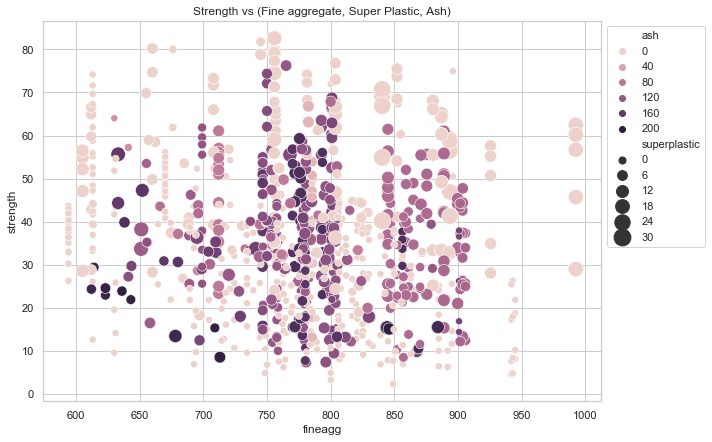

In [390]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="strength", x="fineagg", hue="ash", size="superplastic", 
                data=df, ax=ax, sizes=(50, 300))
ax.set_title("Strength vs (Fine aggregate, Super Plastic, Ash)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

**Observations from CC Strength vs (Fine aggregate, Super Plastic, Ash)**
- As Ash increases the strength decreases
- Strength increases with Super plastic

##### Strength vs (Fine aggregate, Super Plastic, Water)

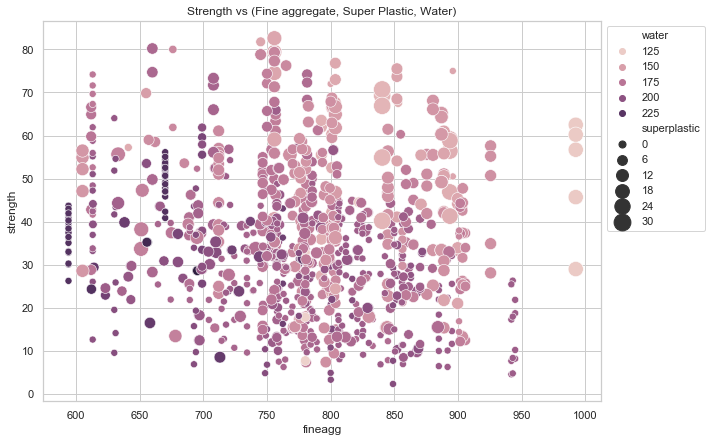

In [391]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(y="strength", x="fineagg", hue="water", size="superplastic", 
                data=df, ax=ax, sizes=(50, 300))
ax.set_title("Strength vs (Fine aggregate, Super Plastic, Water)")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

**Observations from CC Strength vs (Fine aggregate, Super Plasticizer, Water)**
- Strength decreases with increase in water, strength increases with increase in Super plasticizer (already from above plots)
- More Fine aggregate is used when less water, more Super plasticizer is used.

In [393]:
age_df = df.copy()
def label(age_df):
    if age_df["age"] <= 30:
        return "1"
    if age_df["age"] > 30 and age_df["age"] <= 60 :
        return "2"
    if age_df["age"] > 60 and age_df["age"] <= 90 :
        return "3"
    if age_df["age"] > 90 and age_df["age"] <= 120 :
        return "4"
    if age_df["age"] > 120 and age_df["age"] <= 150 :
        return "5"
    if age_df["age"] > 150 and age_df["age"] <= 180 :
        return "6"
    if age_df["age"] > 180 and age_df["age"] <= 210 :
        return "7"
    if age_df["age"] > 210 and age_df["age"] <= 240 :
        return "8"
    if age_df["age"] > 240 and age_df["age"] <= 270 :
        return "9"
    if age_df["age"] > 270 and age_df["age"] <= 300 :
        return "10"
    if age_df["age"] > 300 and age_df["age"] <= 330 :
        return "11"
    if age_df["age"] > 330 :
        return "12"
age_df["age_months"] = age_df.apply(lambda age_df:label(age_df) , axis=1)

In [394]:
age_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,age_months
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1


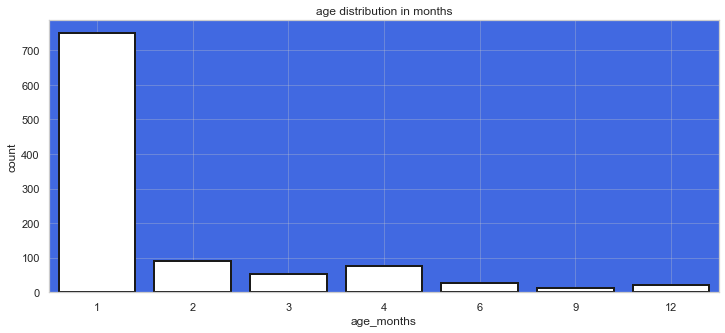

In [395]:
plt.figure(figsize=(12,5))
order = ['1','2', '3','4','6','9', '12']
ax = sns.countplot(age_df["age_months"],
                   order=order,linewidth=2,
                   edgecolor = "k"*len(order),
                   palette=["w"])
ax.set_facecolor("royalblue")
plt.title("age distribution in months")
plt.grid(True,alpha=.3)
plt.show()

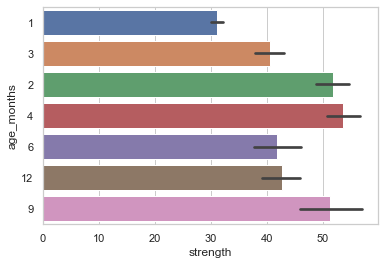

In [396]:
sns.barplot(x="strength",y="age_months",data=age_df)

**Observation**

- majority of dataset has a lot more age in days under 30 days
- the second barplot shows that concrete strength get stronger the longer the days are.

### Outlier Treatment

##### Boxplot to show various outliers

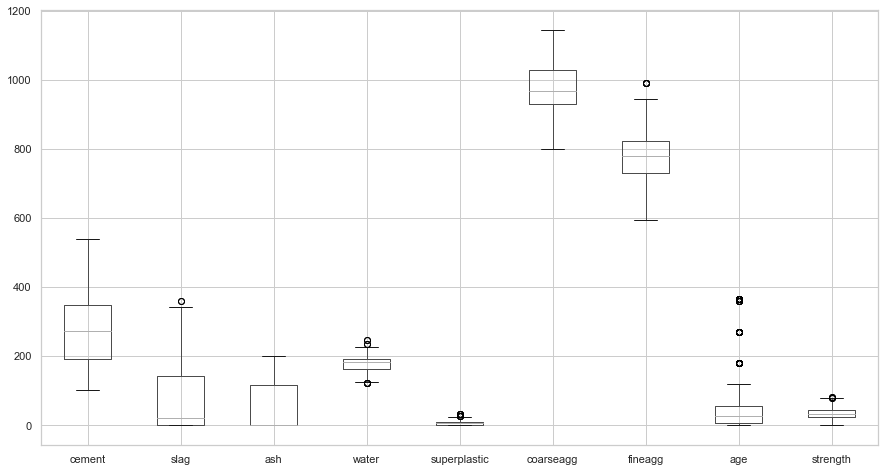

In [397]:
df.boxplot(figsize = (15,8))

If it's greater than 3 standard deviations it will be considered an outlier

In [398]:
print('Outliers in cement: ', df[((df.cement - df.cement.mean()) / df.cement.std()).abs() > 3]['cement'].count())
print('Outliers in slag: ', df[((df.slag - df.slag.mean()) / df.slag.std()).abs() > 3]['slag'].count())
print('Outliers in ash: ', df[((df.ash - df.ash.mean()) / df.ash.std()).abs() > 3]['ash'].count())
print('Outliers in water: ', df[((df.water - df.water.mean()) / df.water.std()).abs() > 3]['water'].count())
print('Outliers in superplastic: ', df[((df.superplastic - df.superplastic.mean()) / df.superplastic.std()).abs() > 3]['superplastic'].count())
print('Outliers in coarseagg: ', df[((df.coarseagg - df.coarseagg.mean()) / df.coarseagg.std()).abs() > 3]['coarseagg'].count())
print('Outliers in fineagg: ', df[((df.fineagg - df.fineagg.mean()) / df.fineagg.std()).abs() > 3]['fineagg'].count())
print('Outliers in age: ', df[((df.age - df.age.mean()) / df.age.std()).abs() > 3]['age'].count())

Outliers in cement:  0
Outliers in slag:  4
Outliers in ash:  0
Outliers in water:  2
Outliers in superplastic:  10
Outliers in coarseagg:  0
Outliers in fineagg:  0
Outliers in age:  33


Outliers are extreme values in the data which are far away from most of the values. You can see them as the tails in the histogram.

Outlier must be treated one column at a time. As the treatment will be slightly different for each column.

Why I should treat the outliers?

Outliers bias the training of machine learning models. As the algorithm tries to fit the extreme value, it goes away from majority of the data.

There are below two options to treat outliers in the data.

- Option-1: Delete the outlier Records. Only if there are just few rows lost.
- Option-2: Impute the outlier values with a logical business value

##### Replacing outliers by median

In [399]:
outlier_df = df

In [400]:
for cols in outlier_df.columns[:-1]:
    Q1 = outlier_df[cols].quantile(0.25)
    Q3 = outlier_df[cols].quantile(0.75)
    iqr = Q3-Q1
    
    low = Q1-1.5*iqr
    high = Q3+1.5*iqr
    outlier_df.loc[(outlier_df[cols] < low) | (outlier_df[cols] > high), cols] = outlier_df[cols].median()

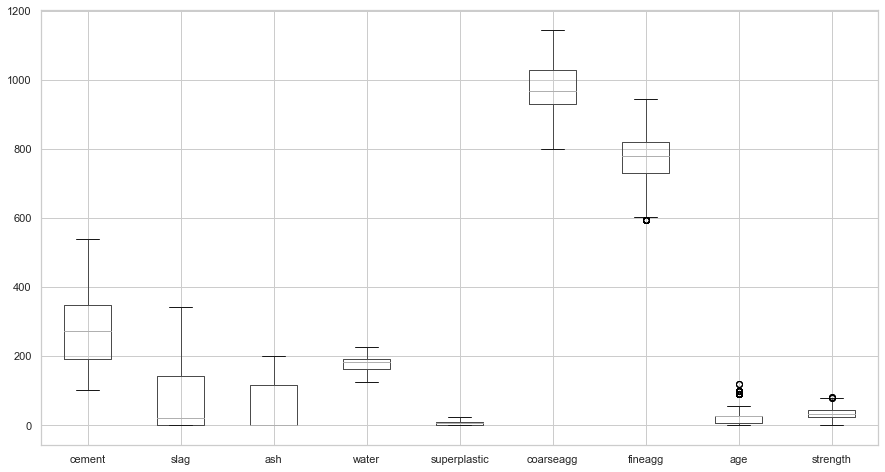

In [401]:
outlier_df.boxplot(figsize = (15,8))

Compared with the first boxplot, most of the outliers have been reduced and some have even diappeared

### Feature Selection using the statistical Pearson's correlation coefficient value

##### Heat map correlation between the attributes

Pearson's correlation coefficient can simply be calculated as the covariance between two features  𝑥  and  𝑦  (numerator) divided by the product of their standard deviations (denominator)

- This value can be calculated only between two numeric columns
- Correlation between [-1,0] means inversely proportional, the scatter plot will show a downward trend
- Correlation between [0,1] means directly proportional, the scatter plot will show a upward trend
- Correlation near {0} means No relationship, the scatter plot will show no clear trend.
- If Correlation value between two variables is > 0.5 in magnitude, it indicates good relationship the sign does not matter
- We observe the correlations between Target variable and all other predictor variables(s) to check which columns/features/predictors are actually related to the target variable in question

In [402]:
df_corr = df

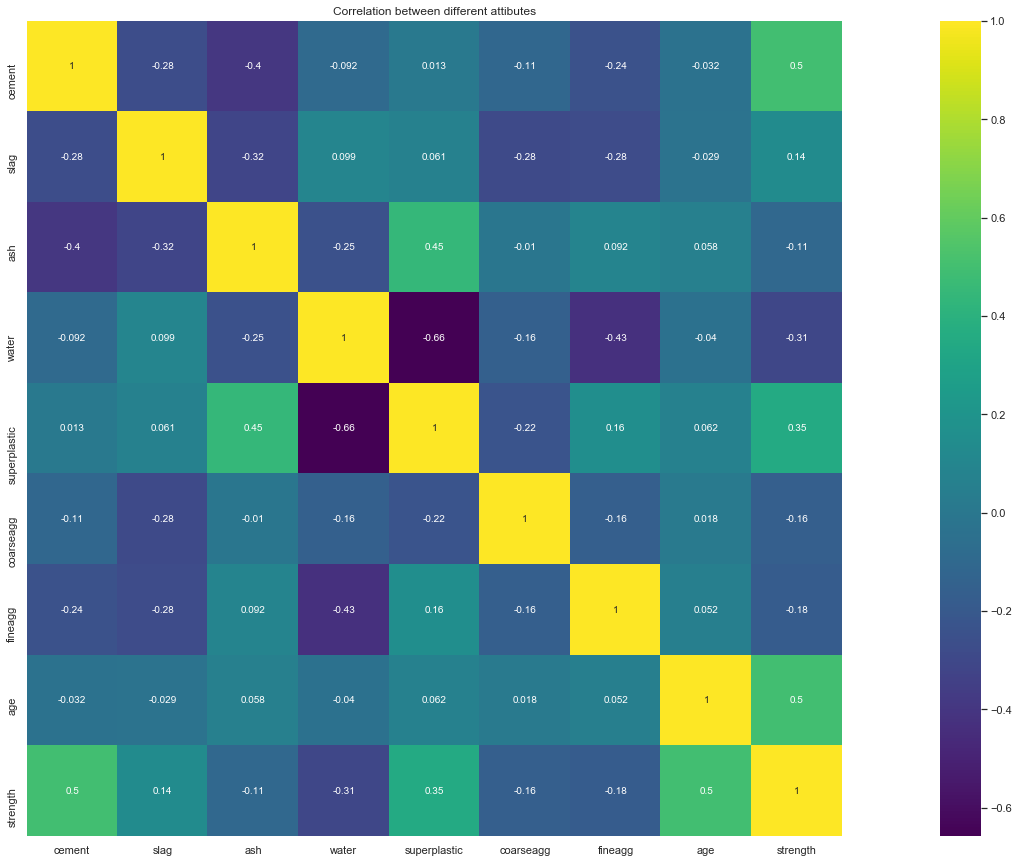

In [403]:
plt.figure(figsize = (35,15))
sns.heatmap(df_corr.corr(),vmax=1, square=True, annot=True, cmap='viridis')
plt.title('Correlation between different attibutes')
plt.show()

###### Correlation Matrix

**Observations**
- There aren't any high correlations between Compressive strength and other features except for Cement, which should be the case for more strength. As expected, cement and age have strong correlation with strength.
- Age and Super plasticizer are the other two features which are strongly correlated with Compressive Strength.
- Super Plastic seems to have a negative high correlation with Water, positive correlations with Fly ash and Fine aggregate.
- We can further analyze these correlations visually by plotting these relations.
- None of the variables are strongly correlated...hence PCA is not necessary to be performed

In [404]:
# Correlation matrix version #1
ContinuousCols=['strength','cement','slag','ash','water','superplastic','coarseagg','fineagg','age']

# Creating the correlation matrix
df_corr=df_corr[ContinuousCols].corr()
df_corr

,strength,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
strength,1.000000,0.497832,0.137800,-0.105755,-0.307711,0.346260,-0.164935,-0.182186,0.499850
cement,0.497832,1.000000,-0.275046,-0.397467,-0.091614,0.013336,-0.109349,-0.238698,-0.031962
slag,0.137800,-0.275046,1.000000,-0.320468,0.098880,0.061195,-0.283882,-0.282383,-0.028971
ash,-0.105755,-0.397467,-0.320468,1.000000,-0.248011,0.447492,-0.009961,0.091729,0.057928
water,-0.307711,-0.091614,0.098880,-0.248011,1.000000,-0.658056,-0.156928,-0.426299,-0.040304
superplastic,0.346260,0.013336,0.061195,0.447492,-0.658056,1.000000,-0.224503,0.156591,0.062013
coarseagg,-0.164935,-0.109349,-0.283882,-0.009961,-0.156928,-0.224503,1.000000,-0.161377,0.018078
fineagg,-0.182186,-0.238698,-0.282383,0.091729,-0.426299,0.156591,-0.161377,1.000000,0.051532
age,0.499850,-0.031962,-0.028971,0.057928,-0.040304,0.062013,0.018078,0.051532,1.000000


##### Correlation of Strength to other features

In [405]:
# Correlation matrix 
corrMatrix = df_corr[df_corr.columns[0:]].corr()['strength'][:]
corrMatrix = corrMatrix.to_frame()

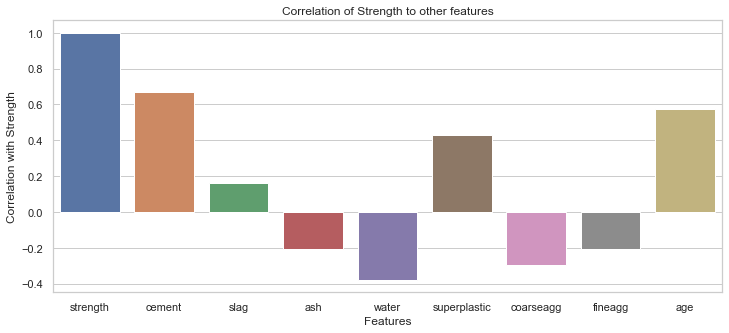

,strength
strength,1.000000
cement,0.667996
slag,0.159452
ash,-0.205378
water,-0.379126
superplastic,0.427718
coarseagg,-0.295020
fineagg,-0.204930
age,0.574415


In [406]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.barplot(x = corrMatrix.index,y = corrMatrix['strength'],data = corrMatrix)
plt.title('Correlation of Strength to other features')
plt.ylabel('Correlation with Strength')
plt.xlabel('Features')
plt.show()
corrMatrix

**Observations**
It is clear from the graph that :

- Cement
- Superplasticizer
- Age

have a positive effect on the Concrete's Strength, while, Water has a large negative effect when compared to other negative factors


The cement Strength can vary between min - 17Mpa , 18-28 Mpa and 28 - <70 Mpa,
we could have df divided into three.

- It is evident that cement and age, superplastic have good positive corr with strength, cement being the strong predictor.
- Water has a strong negative correlation with Strength, where are there are other variables with very less correlation there are good correlation amoung variables: cement -> Slag = -ve relation and strength-> +ve Slag -> ash and fineaggg = -ve Water -> superplastic , fineagg strength = -ve superplastic -> ash and Strength positive correlation between water and slag age -> Strength and water

### Machine Learning: Splitting the data into Training and Testing sample
We dont use the full data for creating the model. Some data is randomly selected and kept aside for checking how good the model is. This is known as Testing Data and the remaining data is called Training data on which the model is built. Typically 70% of data is used as Training data and the rest 30% is used as Tesing data.

##### Standardization/Normalization of data

Normalization is the preprocessing step in machine learning. The normalization methods are used where the variation intervals of the variables in the dataset differ. When the mean and variance of the variables differ significantly, the variables with a large mean and variance increase the impact on the other variables. This may result in the loss of important variables due to the low variation intervals. It can also affect the success of the machine learning models. Therefore, regression models are normalized by the numerical data normalization methods to standardize the effect of each variable on the results. In this study, the dataset was normalized by the z-score normalization techniques.

In [407]:
## Sandardization of data ###
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Choose either standardization or Normalization
# On this data Min Max Normalization produced better results

# Choose between standardization and MinMAx normalization
# #PredictorScaler=StandardScaler()
# PredictorScaler=MinMaxScaler()

# # Storing the fit object for later reference
# PredictorScalerFit=PredictorScaler.fit(X)

# # Generating the standardized values of X
# X=PredictorScalerFit.transform(X)

# # # Independent and dependent variables
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


A naive approach to preparing data applies the transform on the entire dataset before evaluating the performance of the model. This results in a problem referred to as data leakage, where knowledge of the hold-out test set leaks into the dataset used to train the model. This can result in an incorrect estimate of model performance when making predictions on new data.

To prevent data leakage we dividing data into  train-test splits or k-fold cross-validation.

In [408]:
# Splitting the data into independent and dependent attributes

X = df.drop('strength', axis=1)
y = df['strength']

In [409]:
from scipy.stats import zscore

Xscaled = X.apply(zscore)
Xscaled_df = pd.DataFrame(Xscaled, columns = df.columns)

In [410]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y,  test_size = 0.3, random_state = 1)

**Model Evaluation:**
- model.score() is the same thing as model.r2_score(). It here were are scoring based on the predictive power of the model with testing data. 

- 100% means perfect correlation. Yet, there are models with a low R2 that are still good models.

- metrics.mean_squared_error is being used to get the average of the square of the errors. The larger the number the larger the error means the difference between the observed values and the predicted ones. 

- There is no correct value for MSE. Simply put, the lower the value the better and 0 means the model is perfect. Since there is no correct answer, the MSE’s basic value is in selecting one prediction model over another.

- Our take away message here is that you cannot look at these metrics in isolation in sizing up your model. You have to look at other metrics as well, plus understand the underlying math. We will get into all of this after we have iterated through all the models.run.

## Linear Models

Since linear regression models are affected by outliers, I will remove them useing the dataset above with outlier treatment (outlier_df)

### Linear Regression - OLS

In [411]:
import statsmodels.api as sm
X=outlier_df.iloc[:,:8]
Y=outlier_df.iloc[:,8]

In [412]:
ls=sm.OLS(Y,sm.add_constant(X))
results=ls.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     322.1
Date:                Sat, 23 Jan 2021   Prob (F-statistic):          4.71e-273
Time:                        01:55:35   Log-Likelihood:                -3712.6
No. Observations:                1030   AIC:                             7443.
Df Residuals:                    1021   BIC:                             7488.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           40.5554     19.416      2.089      0.037       2.456      78.655
cement           0.0996      0.006     15.628      0.000       0.087       0.112
slag             0.0690      0.008      9.100      0.000       0.054       0.084
ash              0.0367      0.009      3.900      0.000       0.018       0.055
water           -0.1720      0.031     -5.477      0.000      -0.234      -0.110
superplastic     0.2682      0.089      3.013      0.003       0.094       0.443
coarseagg       -0.0067      0.007     -0.988      0.323      -0.020       0.007
fineagg         -0.0175      0.008     -2.203      0.028      -0.033      -0.002
age              0.3080      0.010     30.580      0.000       0.288       0.328
==============================================================================
Omnibus:                       46.397   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.172
Skew:                           0.459   Prob(JB):                     3.85e-13
Kurtosis:                       3.700   Cond. No.                     9.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Observation**
Here we can see that the constant term is having P value greater than 0.05 viz. the assumed level of significance, thus we remove the constant term from modelling below

In [413]:
ls=sm.OLS(Y,X)
results=ls.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               strength   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              2383.
Date:                Sat, 23 Jan 2021   Prob (F-statistic):                        0.00
Time:                        01:55:35   Log-Likelihood:                         -3714.8
No. Observations:                1030   AIC:                                      7446.
Df Residuals:                    1022   BIC:                                      7485.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cement           0.1108      0.004     31.517      0.000       0.104       0.118
slag             0.0817      0.005     18.019      0.000       0.073       0.091
ash              0.0499      0.007      7.136      0.000       0.036       0.064
water           -0.1131      0.014     -8.189      0.000      -0.140      -0.086
superplastic     0.3394      0.082      4.123      0.000       0.178       0.501
coarseagg        0.0064      0.003      2.400      0.017       0.001       0.012
fineagg         -0.0021      0.003     -0.709      0.478      -0.008       0.004
age              0.3071      0.010     30.466      0.000       0.287       0.327
==============================================================================
Omnibus:                       48.008   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.933
Skew:                           0.465   Prob(JB):                     9.68e-14
Kurtosis:                       3.730   Cond. No.                         384.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Without the constant term we can observe that the R-squared value has increased drastically.

### Linear Regression

In [414]:
lr=LinearRegression()
lr.fit(X_train,y_train)
print('Score: ',lr.score(X_train,y_train))
y_pred_lrtr=lr.predict(X_train)
y_pred_lrte=lr.predict(X_test)

from sklearn.metrics import r2_score
print('Train R2 score: ',r2_score(y_train,y_pred_lrtr))
print('Test R2 score: ',r2_score(y_test,y_pred_lrte))

Score:  0.7214971210103257
Train R2 score:  0.7214971210103257
Test R2 score:  0.6981381588376172


### Polynomial Regression - Degree 2

In [415]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 2)
X_polytr = pf.fit_transform(X_train)
lr.fit(X_polytr,y_train)
y_pred_lr2tr = lr.predict(X_polytr)
print("Training R2 - degree 2 polynomial: ",r2_score(y_train, y_pred_lr2tr ))
X_polyte = pf.fit_transform(X_test)
y_pred_lr2te= lr.predict(X_polyte)
print("Test R2 - degree 2 polynomial: ",r2_score(y_test,y_pred_lr2te))

Training R2 - degree 2 polynomial:  0.8620237272650242
Test R2 - degree 2 polynomial:  0.8372393147334634


### Polynomial Regression - Degree 3

In [416]:
pf = PolynomialFeatures(degree = 3)
X_polytr = pf.fit_transform(X_train)
lr.fit(X_polytr,y_train)
y_pred_lr2tr = lr.predict(X_polytr)
print("Training R2 - degree 3 polynomial: ",r2_score(y_train, y_pred_lr2tr ))
X_polyte = pf.fit_transform(X_test)
y_pred_lr2te= lr.predict(X_polyte)
print("Test R2 - degree 3 polynomial: ",r2_score(y_test,y_pred_lr2te))

Training R2 - degree 3 polynomial:  0.9419719814677285
Test R2 - degree 3 polynomial:  0.875640868057098


### Polynomial Regression - Degree 4

In [417]:
pf = PolynomialFeatures(degree = 4)
X_polytr = pf.fit_transform(X_train)
lr.fit(X_polytr,y_train)
y_pred_lr2tr = lr.predict(X_polytr)
print("Training R2 - degree 4 polynomial: ",r2_score(y_train, y_pred_lr2tr ))
X_polyte = pf.fit_transform(X_test)
y_pred_lr2te= lr.predict(X_polyte)
print("Test R2 - degree 4 polynomial: ",r2_score(y_test,y_pred_lr2te))

Training R2 - degree 4 polynomial:  0.9836735288520663
Test R2 - degree 4 polynomial:  -7654.82786328994


**Observation**

Beyond this, the model does not perform well. From this it is clear that the model is non linear. Thus we proceed to other non-linear models.

## Non-Linear Models

**Outliers and multicollinearity**
The following models are not sensitive to outliers or multicollinearity so we can use the original dataset as it
- Random forest and bagging
- decision trees and boosted trees algorithms 
- gradient boosting 
- AdaBoost
- XGBoost

KNN and Support Vector Machines are affected by outliers or multicollinearity, however as you shall see, the RSquare scores are so low that they aren't worth the effort fine tune.


**k-Fold Cross-Validation**
- Evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: **overfitting**.

- If we optimize the model for the training data, then our model will score very well on the training set, but will not be able to generalize to new data, such as in a test set. When a model performs highly on the training set but poorly on the test set, this is known as overfitting, or essentially creating a model that knows the training set very well but cannot be applied to new problems. It’s like a student who has memorized the simple problems in the textbook but has no idea how to apply concepts in the messy real world.

- An overfit model may look impressive on the training set, but will be useless in a real application. Therefore, the standard procedure for hyperparameter optimization accounts for overfitting through cross validation.

- I am using K-fold cross validation to estimate the skill of the model on new unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

- It is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill.

The procedure is as follows:
- Shuffle the dataset randomly.
- Split the dataset into k groups
- For each unique group:
- Take the group as a hold out or test data set
- Take the remaining groups as a training data set
- Fit a model on the training set and evaluate it on the test set
- Retain the evaluation score and discard the model
- Summarize the skill of the model using the sample of model evaluation scores


**Random Search Cross Validation in Scikit-Learn**

- Further optimising the base model by tuning the hyperparameters using Scikit-Learn’s RandomizedSearchCV method, to define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.



### 1. Random Forest

In [418]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [419]:
y_pred = model.predict(X_test)

Model performance on Training Data.

Obviously this is going to do well, like sitting an exam after knowing the questions

In [420]:
model.score(X_train, y_train)

0.979808359990965

In [421]:
# Model performance on Testing Data (RSquare score)

model.score(X_test, y_test)

0.9059027053952895

In [422]:
# same thing as above:

# metrics.r2_score(y_test, y_pred)

**Observation**

The model score on test data is lower than the training data. It should be much closer to the training data, so somehow our this model is overfitted

In [423]:
# Check the score on the y_test and the prediction

acc_R = metrics.r2_score(y_test, y_pred)
acc_R

0.9059027053952895

In [424]:
metrics.mean_squared_error(y_test, y_pred)

27.386035125361467

Mean squared error is actually quite large, so we need to hypertune the parameters to try to minimise these errors (describe what the mean squared error is) - smaller it is the better it is

In [425]:
# Store the accuracy results for each model in dataframe for final comparison

results_1 = pd.DataFrame({'Algorithm':['Random Forest'], 'R^2 Test Score': acc_R}, index={'1'})
results = results_1[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903


### 2. KFold Cross Validation on Random Forest Regressor

In [426]:
k = 20

kfold = KFold(n_splits = k, random_state = 1)
K_results = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(K_results))
accuracy

0.913310893523043

In [427]:
# 20 different K experiments and finding the mean of that - we are getting 91% accuracy
K_results

array([0.86259333, 0.8871968 , 0.86410947, 0.89053036, 0.95287206,
       0.95246131, 0.89842459, 0.91543652, 0.92812185, 0.85012437,
       0.94579398, 0.93267118, 0.90711926, 0.93638216, 0.8949829 ,
       0.90893346, 0.92826321, 0.94082799, 0.92905275, 0.94032034])

In [428]:
# Store the accuracy results for each model in dataframe for final comparison

random_re = pd.DataFrame({'Algorithm':['Random Forest Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'2'})
results = pd.concat([results, random_re])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311


### 3. Hyperparameter tuning Random Forest with Random Search

In [429]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Looking documentation on the random forest in Scikit-Learn tells us what the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features).

In [430]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Now, we instantiate the random search and fit it like any Scikit-Learn model:

In [431]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [432]:
# We can view the best parameters from fitting the random search:

rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [433]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_train)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [434]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

Model Performance
Average Error: 1.8644 degrees.
Accuracy = 93.73%.


In [435]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

Model Performance
Average Error: 1.5226 degrees.
Accuracy = 94.78%.


In [436]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.11%.


In [437]:
tuned_rf = random_accuracy
tuned_rf

94.77663817370816

In [438]:
# Store the accuracy results for each model in dataframe for final comparison

tuned_rf_1 = pd.DataFrame({'Algorithm':['Tuned Random Forest'], 'R^2 Test Score': [tuned_rf]}, index={'3'})
results = pd.concat([results, tuned_rf_1])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638


### 4. Gradient Boost Regressor

In [439]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [440]:
y_pred = model.predict(X_test)

In [441]:
# Training data
model.score(X_train, y_train)

0.9430469892492804

In [442]:
acc_G = metrics.r2_score(y_test, y_pred)
acc_G

0.8920909625156171

In [443]:
# Testing data
model.score(X_test, y_test)

0.8920909625156171

Gap between train and test accuracy is huge so it is overfitting

In [444]:
metrics.mean_squared_error(y_test, y_pred)

31.40579868215808

The mean squared error is similar to that of Radom Forest

In [445]:
# Store the accuracy results for each model in dataframe for final comparison

gradient_re = pd.DataFrame({'Algorithm':['Gradient Boosting Regressor'], 'R^2 Test Score': [acc_G]}, index={'4'})
results = pd.concat([results, gradient_re])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091


### 5. KFold Cross Validation on Gradient Boosting Regressor

In [446]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_3 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_3))
accuracy

0.8995331412998333

In [447]:
# 20 different K experiments and finding the mean of that - we are getting 91% accuracy
results_3

array([0.88380543, 0.89204988, 0.87662742, 0.88698034, 0.93763475,
       0.89833982, 0.86726238, 0.91602011, 0.91747912, 0.83134784,
       0.91893385, 0.91785797, 0.92901382, 0.9050695 , 0.92343111,
       0.86167351, 0.92657187, 0.91174031, 0.89481956, 0.89400424])

In [448]:
# Store the accuracy results for each model in dataframe for final comparison

gradient_k = pd.DataFrame({'Algorithm':['Gradient Boosting Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'5'})
results = pd.concat([results, gradient_k])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533


### 6. Hyperparameter tuning Gradient Boost with Random Search

In [449]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state = 1)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [450]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
criterion = ['friedman_mse']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion':criterion}
pprint(random_grid)

{'criterion': ['friedman_mse'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [451]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
gb = GradientBoostingRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Fit the random search model
gb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [452]:
gb_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'friedman_mse'}

In [453]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = GradientBoostingRegressor(n_estimators = 10, random_state = 1)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 9.2139 degrees.
Accuracy = 61.49%.


In [454]:
best_random = gb_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 3.3230 degrees.
Accuracy = 88.64%.


In [455]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 44.16%.


In [456]:
tuned_gb = random_accuracy
tuned_gb

88.64236586839952

In [457]:
# Store the accuracy results for each model in dataframe for final comparison

gb_tuned = pd.DataFrame({'Algorithm':['Tuned Ada Boost Regressor'], 'R^2 Test Score': [tuned_gb]}, index={'6'})
results = pd.concat([results, gb_tuned])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366


### 7. Ada Boosting Regressor

In [458]:
model = AdaBoostRegressor()
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [459]:
y_pred = model.predict(X_test)

In [460]:
# Training data
model.score(X_train, y_train)

0.8129925193999841

In [461]:
acc_Ada = metrics.r2_score(y_test, y_pred)
acc_Ada

0.7682896333537337

In [462]:
# Testing data
model.score(X_test, y_test)

0.7682896333537337

Again, this is a bit low compared to train data hence overfitting

In [463]:
metrics.mean_squared_error(y_test, y_pred)

67.436882925722

This performed badly; mean squared error is really high; it was high before with 31, and this is more than double

In [464]:
# Store the accuracy results for each model in dataframe for final comparison

ada_Ada = pd.DataFrame({'Algorithm':['Ada Boost Regressor'], 'R^2 Test Score': [acc_Ada]}, index={'7'})
results = pd.concat([results, ada_Ada])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290


### 8. KFold Cross Validation on Ada Boost Regressor

In [465]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_4 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_4))
accuracy

0.774559505198947

In [466]:
# Store the accuracy results for each model in dataframe for final comparison

acc_AdaC = pd.DataFrame({'Algorithm':['Ada Boost Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'8'})
results = pd.concat([results, acc_AdaC])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560


### 9. KNN Regressor

We need to choose the range of k wisely
k represents the number of neighbours that we. Here we don't really know the k so we will test a range from 1 to 45

In [467]:
# Checking for different values of neighbours for k as we are not sure whick k to choose
diff_k=[]
for i in range(1,45):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    diff_k.append(np.mean(pred_i!=y_test))

Text(0, 0.5, 'Mean error')

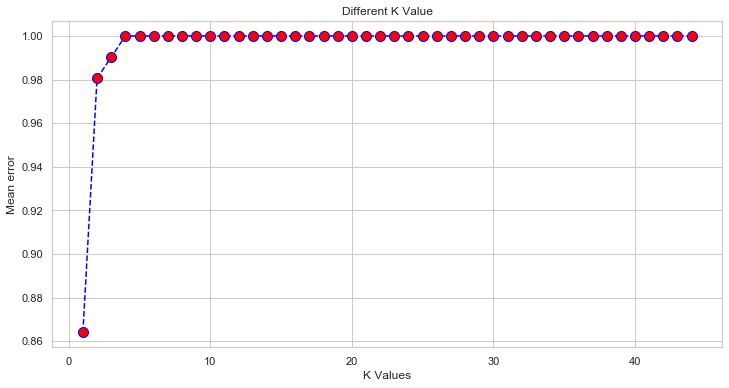

In [468]:
plt.figure(figsize=(12,6))
plt.plot(range(1,45), diff_k, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Different K Value')
plt.xlabel('K Values')
plt.ylabel('Mean error')

In [469]:
# k=3 is a better choice from the above plot where it peaks at the bend.

model = KNeighborsRegressor(n_neighbors = 3)
model.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [470]:
y_pred = model.predict(X_test)

In [471]:
# Training data
model.score(X_train, y_train)

0.8902196318573777

In [472]:
# Test data
acc_KNN = metrics.r2_score(y_test, y_pred)
acc_KNN

0.8078817663272165

In [473]:
metrics.mean_squared_error(y_test, y_pred)

55.91400600503415

Difference between training and test score is large enought to indicate overfitting

The mean squared error is quite huge

In [474]:
# Store the accuracy results for each model in dataframe for final comparison

KNN_df = pd.DataFrame({'Algorithm':['KNN Regressor'], 'R^2 Test Score': [acc_KNN]}, index={'9'})
results = pd.concat([results, KNN_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882


### 10. KFold Cross Validation on KNN Regressor

In [475]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_5 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_5))
accuracy

0.7142936189858564

In [476]:
# Store the accuracy results for each model in dataframe for final comparison

KNNKfold_df = pd.DataFrame({'Algorithm':['KNN  Regressor k fold'], 'R^2 Test Score': [accuracy]}, index={'10'})
results = pd.concat([results, KNNKfold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 11. Bagging Regressor

In [477]:
model = BaggingRegressor()
model.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [478]:
y_pred = model.predict(X_test)

In [479]:
# Training data
model.score(X_train, y_train)

0.9730105562899233

In [480]:
# Testing data
model.score(X_test, y_test)

0.9015676447106721

In [481]:
test = model.score(X_test, y_test)

In [482]:
acc_BR = metrics.r2_score(y_test, y_pred)
acc_BR

0.9015676447106721

It's supposed to be closer to the training score, so there's still something we can do to tune the hyper parameter later on

In [483]:
metrics.mean_squared_error(y_test, y_pred)

28.647709275274405

Error is a bit less that the other

In [484]:
# Store the accuracy results for each model in dataframe for final comparison

Bagging_df = pd.DataFrame({'Algorithm':['Bagging Regressor'], 'R^2 Test Score': [acc_BR]}, index={'11'})
results = pd.concat([results, Bagging_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 12. KFold Cross Validation on Bagging Regressor

In [485]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_6 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_6))
accuracy

0.9047999626984442

In [486]:
# Store the accuracy results for each model in dataframe for final comparison

BaggingKFold_df = pd.DataFrame({'Algorithm':['Bagging Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'12'})
results = pd.concat([results, BaggingKFold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 12. Support Vector Regressor

In [487]:
model = SVR(kernel='linear')
model.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

if the kernel='linear' is not doing well we can always change the kernal which is part of the hyperparameter tuning

In [488]:
y_pred = model.predict(X_test)

In [489]:
# Training data
model.score(X_train, y_train)

0.7181086245967501

even on training data the accuracy is doing quite bad

In [490]:
# Testing data
model.score(X_test, y_test)

0.6907906495008019

69% is really bad

In [491]:
acc_G = metrics.r2_score(y_test, y_pred)
acc_G

0.6907906495008019

In [492]:
metrics.mean_squared_error(y_test, y_pred)

89.99215300965027

So far this is the higest error out of all the models. Overall this is the worst performing model for this data set.

In [493]:
# Store the accuracy results for each model in dataframe for final comparison

SVR_df = pd.DataFrame({'Algorithm':['Support Vector Regressor'], 'R^2 Test Score': [acc_G]}, index={'13'})
results = pd.concat([results, SVR_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 14. KFold Cross Validation on Support Vector Regressor

In [494]:
k = 10

kfold = KFold(n_splits = k, random_state = 70)
results_3 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_3))
accuracy

0.6979816289197182

We changed the k to 10 instead of 20; it's a hyperparameter so we can change it depending on the judgement. Here it is taking way too much compute power and is running forever, hence halving the k to 10 makes sense. Obvioulsy it also depends on accuracy too and there wasn't much difference. Both were quite low.

In [495]:
# Store the accuracy results for each model in dataframe for final comparison

SVRKFold_df = pd.DataFrame({'Algorithm':['Support Vector Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'14'})
results = pd.concat([results, SVRKFold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 15. XGBoost Regressor

In [496]:
# import sys
# !{sys.executable} -m pip install xgboost

In [497]:
from xgboost.sklearn import XGBRegressor

In [498]:
import xgboost as xgb

In [499]:
xgr = XGBRegressor()
xgr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [500]:
y_pred = xgr.predict(X_test)

In [501]:
# Training data
xgr.score(X_train, y_train)

0.9911871603853496

In [502]:
# Testing data
xgr.score(X_test, y_test)

0.8995864694504011

In [503]:
acc_XGB = metrics.r2_score(y_test, y_pred)
acc_XGB

0.8995864694504011

In [504]:
metrics.mean_squared_error(y_test, y_pred)

29.22430964933621

In [505]:
# Store the accuracy results for each model in dataframe for final comparison

XGB_df = pd.DataFrame({'Algorithm':['XGBoost Regressor'], 'R^2 Test Score': [acc_XGB]}, index={'15'})
results = pd.concat([results, XGB_df])
results = results[['Algorithm', 'R^2 Test Score']]
results


,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 16. KFold Cross Validation on XGBoost Regressor

In [506]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_13 = cross_val_score(model, X, y, cv=kfold)
accuracy = np.mean(abs(results_13))
accuracy

0.6965540788749465

In [507]:
# Store the accuracy results for each model in dataframe for final comparison

XGBKFold_df = pd.DataFrame({'Algorithm':['XGBoost Regressor k_fold'], 'R^2 Test Score': [accuracy]}, index={'16'})
results = pd.concat([results, XGBKFold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 17. Decision Tree Regression

In [508]:
dec_model = DecisionTreeRegressor()
dec_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [509]:
# Printing the feature importance into a dataframe

print('Feature importances: \n', pd.DataFrame(dec_model.feature_importances_, columns=['importance'], index = X_train.columns))

Feature importances: 
               importance
cement          0.356073
slag            0.094902
ash             0.014103
water           0.129102
superplastic    0.014575
coarseagg       0.034690
fineagg         0.028002
age             0.328552


- cement and age are contributing very well to the strength of concrete
- water is contributing well to the strength of concrete
- slag, ash, superplastic, coarseagg and fineagg are not contributing very well to the strength of concrete

In [510]:
y_pred = dec_model.predict(X_test)

In [511]:
# Training data
dec_model.score(X_train, y_train)

0.9917907420889983

In [512]:
# Testing data
dec_model.score(X_test, y_test)

0.8551758753526021

This is really poor. It's performing really well on the training data but the gap is huge on the test, which means it is really overfitting by a lot

In [513]:
acc_DT = metrics.r2_score(y_test, y_pred)
acc_DT

0.8551758753526021

In [514]:
metrics.mean_squared_error(y_test, y_pred)

42.14954937072996

Mean Squared Error is really high

In [515]:
# Store the accuracy results for each model in dataframe for final comparison

XGB_df = pd.DataFrame({'Algorithm':['Decision Tree'], 'R^2 Test Score': [acc_DT]}, index={'17'})
results = pd.concat([results, XGB_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 18. KFold Cross Validation on Decision Tree

Run it 18 times then find the mean of all the accuracies we've been getting

In [516]:
k = 18

kfold = KFold(n_splits = k, random_state = 70)
results_7 = cross_val_score(dec_model, X, y, cv=kfold)
accuracy = np.mean(abs(results_7))
accuracy

0.8691014772583946

In [517]:
# Store the accuracy results for each model in dataframe for final comparison

DecKFold_df = pd.DataFrame({'Algorithm':['Decision Tree k fold'], 'R^2 Test Score': [accuracy]}, index={'18'})
results = pd.concat([results, DecKFold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


In [518]:
### Create a copy of df in order to drop least important features and work on 
df2 = df.copy()

In [519]:
X = df2.drop(['strength','ash','coarseagg','fineagg'], axis=1)
y = df2['strength']

In [520]:
# Split X andy into training and test set in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

In [521]:
# Scale the data so that no variable will outweight another
X_train = X_train.apply(zscore)

In [522]:
decNew_model = DecisionTreeRegressor()
decNew_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

##### Check feature importance again

In [523]:
print('Feature importances: \n', pd.DataFrame(decNew_model.feature_importances_, columns=['importance'], index = X_train.columns))

Feature importances: 
               importance
cement          0.370431
slag            0.114193
water           0.156430
superplastic    0.030043
age             0.328904


In [524]:
y_pred = decNew_model.predict(X_test)

In [525]:
# Training data
decNew_model.score(X_train, y_train)

0.9910459656545207

In [526]:
# Testing data
decNew_model.score(X_test, y_test)

-3.183420181385348

Really poor comparison to the training set and seems to be underfitting. Underfitting occurs when a model is too simple — informed by too few features or regularized too much — which makes it inflexible in learning from the dataset. Simple learners tend to have less variance in their predictions but more bias towards wrong outcomes.

In [527]:
acc_DT = metrics.r2_score(y_test, y_pred)
acc_DT

-3.1834201813853484

In [528]:
# Store the accuracy results for each model in dataframe for final comparison

Dec_df2 = pd.DataFrame({'Algorithm':['Decision Tree2'], 'R^2 Test Score': [acc_DT]}, index={'19'})
results = pd.concat([results, Dec_df2])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


##### Let's create our training and testing data again since it has been overriden

In [529]:
X = df.drop('strength', axis = 1)
y = df['strength']

In [530]:
Xscaled = X.apply(zscore)
Xscaled_df = pd.DataFrame(Xscaled, columns = df.columns)

In [531]:
# Split X andy into training and test set in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 1)

### 20. Pruning Decision Tree

In [532]:
dec_prun_model = DecisionTreeRegressor(max_depth = 4, random_state = 1, min_samples_leaf = 5)
dec_prun_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

##### Check feature importance

In [533]:
print('Feature importances: \n', pd.DataFrame(dec_prun_model.feature_importances_, columns=['importance'], index = X_train.columns))

Feature importances: 
               importance
cement          0.416953
slag            0.025822
ash             0.000000
water           0.135128
superplastic    0.017987
coarseagg       0.000000
fineagg         0.007793
age             0.396318


- cement, water and age are contributing features
- everthing else is not contributing to concreate strenght

In [534]:
from sklearn import tree

In [535]:
Xscaled_df = Xscaled_df.drop('strength', axis = 1)

In [536]:
feature_cols = Xscaled_df.columns

In [537]:
feature_cols

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

[Text(837.0, 489.24, 'age <= 21.0\nmse = 273.557\nsamples = 721\nvalue = 35.756'),
 Text(418.5, 380.52000000000004, 'cement <= 354.5\nmse = 144.359\nsamples = 230\nvalue = 23.437'),
 Text(209.25, 271.8, 'age <= 10.5\nmse = 73.078\nsamples = 167\nvalue = 18.956'),
 Text(104.625, 163.08000000000004, 'cement <= 238.9\nmse = 42.769\nsamples = 121\nvalue = 15.618'),
 Text(52.3125, 54.360000000000014, 'mse = 23.635\nsamples = 70\nvalue = 12.637'),
 Text(156.9375, 54.360000000000014, 'mse = 40.097\nsamples = 51\nvalue = 19.709'),
 Text(313.875, 163.08000000000004, 'superplastic <= 8.8\nmse = 46.377\nsamples = 46\nvalue = 27.738'),
 Text(261.5625, 54.360000000000014, 'mse = 25.015\nsamples = 31\nvalue = 25.182'),
 Text(366.1875, 54.360000000000014, 'mse = 49.131\nsamples = 15\nvalue = 33.019'),
 Text(627.75, 271.8, 'water <= 153.7\nmse = 139.035\nsamples = 63\nvalue = 35.314'),
 Text(523.125, 163.08000000000004, 'age <= 5.0\nmse = 62.599\nsamples = 11\nvalue = 46.3'),
 Text(470.8125, 54.360000

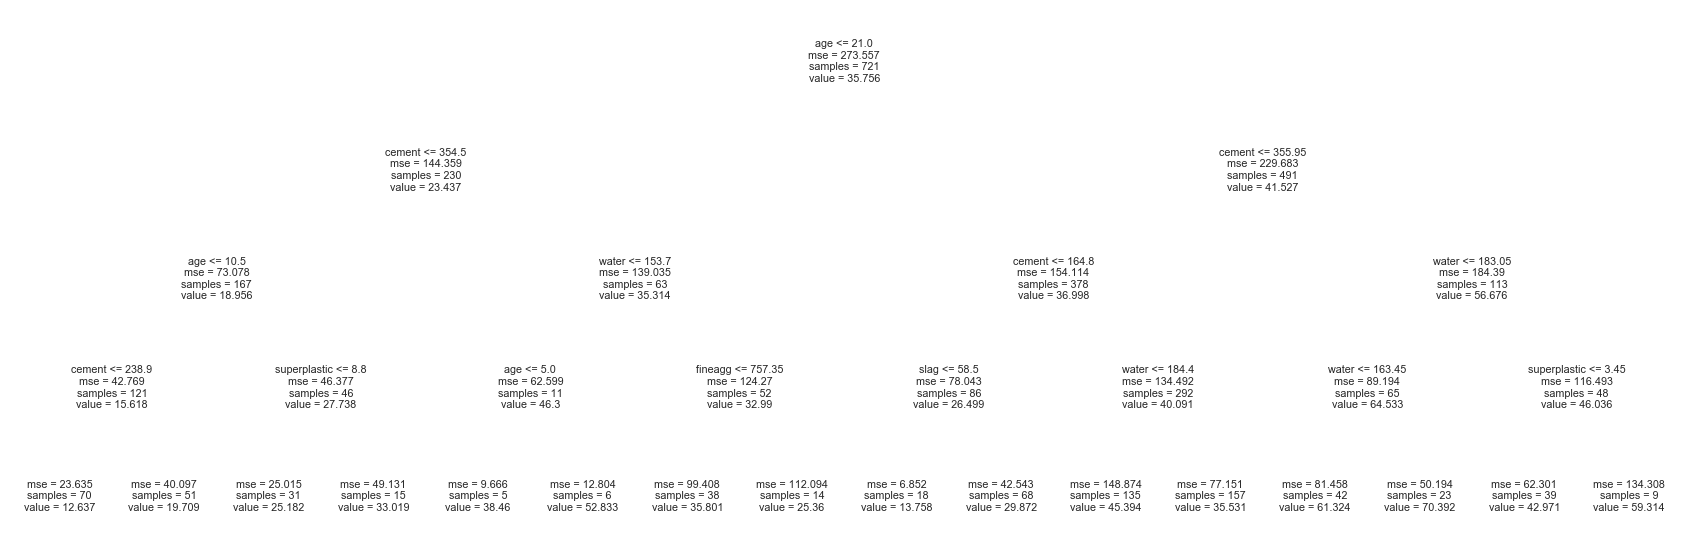

In [538]:
plt.figure(figsize=(30,10))
tree.plot_tree(dec_prun_model,class_names="bool",feature_names=feature_cols)

In [539]:
y_pred = dec_prun_model.predict(X_test)

In [540]:
# Training data
dec_prun_model.score(X_train, y_train)

0.7255811799299219

Exremely bad, esp after pruning. We can't expect much in the testing data (see below)

In [541]:
# Testing data
dec_prun_model.score(X_test, y_test)

0.654827718610513

In [542]:
acc_DecT = metrics.r2_score(y_test, y_pred)
acc_DecT

0.654827718610513

In [543]:
metrics.mean_squared_error(y_test, y_pred)

100.45878855650365

In [544]:

metrics.r2_score(y_test, y_pred)

0.654827718610513

As expected, the error is extremely high, the hightest so far

In [545]:
# Store the accuracy results for each model in dataframe for final comparison

DecT_df = pd.DataFrame({'Algorithm':['Pruned Decision Tree'], 'R^2 Test Score': [acc_DecT]}, index={'20'})
results = pd.concat([results, DecT_df])
results = results[['Algorithm', 'R^2 Test Score']]
results


,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 21. KFold Cross Validation on Pruned Decision Tree

In [546]:
k = 20

kfold = KFold(n_splits = k, random_state = 70)
results_8 = cross_val_score(dec_prun_model, X, y, cv=kfold)
accuracy = np.mean(abs(results_8))
accuracy

0.6785562583989005

Doing very bad 

In [547]:
# Store the accuracy results for each model in dataframe for final comparison

decTKFold_df = pd.DataFrame({'Algorithm':['Pruned Decision Tree k_fold'], 'R^2 Test Score': [accuracy]}, index={'21'})
results = pd.concat([results, decTKFold_df])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


### 22. Hyperparameter tuning Decision Tree with Grid Search

In [548]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [549]:
decision_tree.predict(X_test)

array([50.53      , 48.85      , 35.96      , 23.79      , 17.24      ,
       25.69      , 44.9       , 64.3       , 16.5       , 33.015     ,
       37.23      , 11.17      , 40.93      , 14.2       , 60.95      ,
       22.95      , 37.81      , 26.05      , 24.1       , 35.96      ,
       22.44      , 24.4       , 14.6       , 45.3       , 38.6       ,
       64.9       , 41.16      , 33.4       , 31.97      , 32.84      ,
        9.62      , 42.85      , 24.5       , 50.95      , 24.85      ,
       47.03      , 11.36      , 14.84      , 17.28      , 51.86      ,
       17.22      , 26.97      , 73.7       , 79.4       , 35.96      ,
       33.8       , 23.69      , 13.52      , 32.25      , 50.53      ,
       55.51      , 39.6       , 15.44      , 11.96      , 17.44      ,
       25.1       ,  9.69      , 37.81      , 11.36      , 50.805     ,
       37.23      , 37.27      , 36.47      , 77.3       , 58.52      ,
       49.2       , 24.5       , 11.36      , 23.64      , 22.53

In [550]:
param_dict = {
    "criterion":['mse','friedman_mse','mae', 'poisson'],
    "max_depth":range(1,10),
    "min_samples_split":range(2,10),
    "min_samples_leaf":range(1,5)
}

In [551]:
grid = GridSearchCV(decision_tree,
                   param_grid=param_dict,
                   cv=10,
                   verbose=1,
                   n_jobs=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed:  1.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                         'max_depth': range(1, 10),
                        

In [552]:
grid.best_params_

{'criterion': 'mse',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [553]:
grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [554]:
grid.best_score_

0.8094771295544909

In [555]:
gridDT = grid.best_score_
gridDT

0.8094771295544909

In [556]:
# Store the accuracy results for each model in dataframe for final comparison

grid_DT = pd.DataFrame({'Algorithm':['Grid Search Decision Tree'], 'R^2 Test Score': [gridDT]}, index={'22'})
results = pd.concat([results, grid_DT])
results = results[['Algorithm', 'R^2 Test Score']]
results

,Algorithm,R^2 Test Score
1,Random Forest,0.905903
2,Random Forest Regressor k_fold,0.913311
3,Tuned Random Forest,94.776638
4,Gradient Boosting Regressor,0.892091
5,Gradient Boosting Regressor k_fold,0.899533
6,Tuned Ada Boost Regressor,88.642366
7,Ada Boost Regressor,0.768290
8,Ada Boost Regressor k_fold,0.774560
9,KNN Regressor,0.807882
10,KNN Regressor k fold,0.714294


**Observations:**
- The RSquared score was used for the prediction of model accuracy. 

- The linear regression models were not the right models to use with this type of data set as it did not perform well. We also applied polynomial regression up to quadratic degrees which still performed poorly, and hence it was clear that the solution is not a linear model, and proceeded to other non-linear machine learning algorithms that can handle more hyperplanes.

- On the modelling of non-linear algorithms, I took the chance to experiment with as many algorithms as possible to gain as much insight as I possibly could. 22 in total.

- These included boosting, bagging, KNNs as well as doing my best to prevent overfitting the data. Furthermore, I applied a couple hyper parameters to tune a couple of the models.

- As a result
    - 3 scored an accuracy of above 90, with the tuned random forest with random search scoring 94.75%
    - 7 scored between 85 and 90%
    - 2 scored between 80 and 85%
    - and the rest were pretty poor
    - the worst model was Decision Tree when dropping the least important variables. 

- Interestingly, I used Grid Search hyper parameter tuning on the decision tree (with all the features in) and managed to decrease the accuracy from 84.66% down to 80.53%; whereas using Random Search hyper parameter tuning on the random forest increase the accuracy from 89.76% up to 94.76%.

- Although I didn't apply hyper tuning to all of the models twice, with Grid Search and Random Search, it is a well documented fact that Random Search out performs Grid Search most of the time, takes up less computational power and quicker to run. 

## R SQUARED

RSquared is the predictive power of your model given as a percentage. It determines how well the model fits the data. It is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

**Wikipedia** defines RSquared as

” …the proportion of the variance in the dependent variable that is predictable from the independent variable(s).”

It is measures as a percentage of the response variable variation that is explained by a regression model.

In other words, when we get a Random Forest RSquared result of 90%, it means that the variying levels of strength of concrete can be explained by the independent variables 90% of the time in the  model. 

The remaining 10% are what we call the residuals, which means 10% of the time concrete strength is not explainable by the model at all.

So the RSquared is the percentage% of the variability in y (target varible) that is explained by the variability of independent variables of the model. Not, the entire y(target variable). It is the percentage of the variance in the dependent variable, Strength, that the independent variables explain collectively. 

A common mistake is to say that 90% of the concrete strength is explained by the model. That is not what we are saying. RSqured is saying that 90% of the variability in concrete strength can be explained by the independent variables in the model. A careful distinction must be made here between the two.

**Key Limitations of R-squared:**
    
In general, a model fits the data well if the differences between the observed values and the model's predicted values are small and unbiased. 

R-squared cannot determine whether the coefficient estimates and predictions are biased, which is why you must assess the residual values.

Residual values can reveal unwanted residual patterns that indicate biased results more effectively than numbers. It is a measure of how much a regression line vertically misses a data point

**Are Low R-squared Values Inherently Bad?**

There are instances where a RSquared are not always a bad, and where a high RSquard is not always good.

Quite frankely, there isn't a once rule fits all. The R-squared should accurately reflect the percentage of the dependent variable variation that the linear model explains. Your R2 should not be any higher or lower than this value. A concrete example (no pun intended) where predict human behavior, such as psychology have typically lower than 50%. Humans are simply harder to predict than, say, physical processes.

So in rounding up this summary, a good RSquared depends on the amount of variability that is actually explainable. A practical way of confirming this is a to compare your RSquared model with those from other studies.

In Abrams L.D., Properties of Concrete, by Pitman Publishing Ltd, London (1919), Abrams achieved a RSquared of 98% for the same study and in various studies on the internet plus 90% using Random Forest and Bagging seems to be the norm.







## Inference and recommendations

The Compressive Strength of Concrete determines the quality of Concrete. This is generally determined by a standard crushing test on a concrete cylinder. This requires engineers to build small concrete cylinders with different combinations of raw materials and test these cylinders for strength variations with a change in each raw material. 

The recommended wait time for testing the cylinder is 28 days to ensure correct results. This consumes a lot of time and requires a lot of labour to prepare different prototypes and test them. Also, this method is prone to human error and one small mistake can cause the wait time to drastically increase.

One way of reducing the wait time and reducing the number of combinations to try is to make use of digital simulations, where we can provide information to the computer about what we know and the computer tries different combinations to predict the compressive strength. 

So my study has concluded the following business findings that can help save time, money and resources in order to achieve the optimal concrete strengh with minimum use of resources.

1) 
At first we looked at the overall data set taking a high level overview of the individual features and discovered that there were lots of zeros, but these are in really missing values as stated in the statistical sense because domain knowledge tells us that it is not compulsory to add all the chemical components in to maximise the compression strength of concrete. And in a lot of cases, adding extra chemical components can actually have an adverse effect on the quality as well as the strength of concrete.

2) 
Comparing all the features with the target variable strength, data told us that 

- Cement has strong correlation with strength
- Slag is a very weak predictor 
- Ash, coarseagg and fineagg are also weak predictors
- Water appears to have a negative correlation with strength
- Superplastic appears to have positive correlation with strength
- Age also has strong correlation with strength

3)
- Cement with low age requires more cement for higher strength
- Cement with low age requires more cement for higher strength
- The older the cement is the more water it requires
- Concrete strength increases when less water is used in preparing it
- As Ash increases the strength decreases
- Strength increases with Super plastic
- Strength decreases with increase in water, strength increases with increase in Super plasticizer (already from above plots)
- More Fine aggregate is used when less water, more Super plasticizer is used.

4)
Using the statistical Pearson's correlation coefficient value technique, I was able to identify the most important features affecting concrete strength, namely: Cement, Superplasticizer and Age.

Fly ash, Coarse and Fine aggregates are the least important factors when predicting the Strength of Concrete

5) 
Although the majority of dataset has a lot more age in days under 30 days the barplot shows that concrete strength get stronger the longer the days are.

So my recommendation is to focus on the above findings to understand your business in more detail. Age is a tricky one for business needs because the longer you leave it the stronger it gets, but you can't put the whole construction project on hold for a year while waiting for concrete to get strong. Hence I think most of data points in the age column are under 30 days for practical time scale reasons.


### References:

- Concrete Compressive Strength Prediction using Machine Learning.
https://towardsdatascience.com/concrete-compressive-strength-prediction-using-machine-learning-4a531b3c43f3

- Hyperparameter Tuning of Decision Tree Regressor Using GridSearchCV.
https://medium.com/ai-in-plain-english/hyperparameter-tuning-of-decision-tree-classifier-using-gridsearchcv-2a6ebcaffeda

- The Disadvantages of Fly Ash in Concrete
https://www.hunker.com/13425141/the-disadvantages-of-fly-ash-in-concrete

- Mean Square Error & R2 Score Clearly Explained.
https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/

- Abrams L.D., Properties of Concrete. Pitman Publishing Ltd, London (1919).https://cdn.ymaws.com/concretenz.org.nz/resource/resmgr/docs/conf/2019/s2b_p2.pdf


- Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python. 
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

- A Gentle Introduction to k-fold Cross-Validation.
https://machinelearningmastery.com/k-fold-cross-validation/

- Random Search Cross Validation in Scikit-Learn.
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74